### Стандартные импорты и настройки

In [7]:
import requests
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Scipy

Импортируем функции из библиотеки для кластеризации и векторного квантования.

https://docs.scipy.org/doc/scipy-0.18.1/reference/cluster.vq.html

In [8]:
from scipy.cluster.vq import whiten, kmeans2

### Подключаем API

Для примера используем открытое API, которое предоставляет данные о футбольных командах и матчах. 

http://api.football-data.org/docs/v1/index.html

Для полноценного использования лучше всего получить ключ, это довольно просто.

http://api.football-data.org/register

Для удобства зададим вспомогательный метод для обращения к API.

In [9]:
def call_api(uri, result_key):
    json = {}
    try:
        json = requests.get(uri, headers = { 'X-Auth-Token': 'c52b7825851b4357af3e06c1888152f0' }).json()
        return json[result_key]
    except:
        print(json)
        return None

### Получаем команды

In [10]:
teams = call_api('http://api.football-data.org/v1/soccerseasons/439/teams', 'teams')
teams

[{'_links': {'fixtures': {'href': 'http://api.football-data.org/v1/teams/496/fixtures'},
   'players': {'href': 'http://api.football-data.org/v1/teams/496/players'},
   'self': {'href': 'http://api.football-data.org/v1/teams/496'}},
  'code': None,
  'crestUrl': 'http://upload.wikimedia.org/wikipedia/de/6/63/Rio_Ave_FC.svg',
  'name': 'FC Rio Ave',
  'shortName': 'Rio Ave',
  'squadMarketValue': '21,125,000 €'},
 {'_links': {'fixtures': {'href': 'http://api.football-data.org/v1/teams/503/fixtures'},
   'players': {'href': 'http://api.football-data.org/v1/teams/503/players'},
   'self': {'href': 'http://api.football-data.org/v1/teams/503'}},
  'code': 'FCP',
  'crestUrl': 'http://upload.wikimedia.org/wikipedia/de/e/ed/FC_Porto_1922-2005.svg',
  'name': 'FC Porto',
  'shortName': 'Porto',
  'squadMarketValue': '204,900,000 €'},
 {'_links': {'fixtures': {'href': 'http://api.football-data.org/v1/teams/583/fixtures'},
   'players': {'href': 'http://api.football-data.org/v1/teams/583/players

Для каждой команды получаем игроков и игры.

In [11]:
for team in teams:
    players = call_api(team['_links']['players']['href'], 'players')
    fixtures = call_api(team['_links']['fixtures']['href'], 'fixtures')
    wins = 0
    losts = 0
    for f in fixtures:
        if team['name'] == f['homeTeamName']:
            wins += f['result']['goalsHomeTeam'] if f['result']['goalsHomeTeam'] else 0
        else:
            wins += f['result']['goalsAwayTeam'] if f['result']['goalsAwayTeam'] else 0
    for f in fixtures:
        if team['name'] != f['homeTeamName']:
            losts += f['result']['goalsHomeTeam'] if f['result']['goalsHomeTeam'] else 0
        else:
            losts += f['result']['goalsAwayTeam'] if f['result']['goalsAwayTeam'] else 0
    cost = 0.0
    if team['squadMarketValue']:
        cost = float(re.sub("\D", "", team['squadMarketValue']))
    print('Team "{}", {} players, {} wins, {} losts, {} cost'.format(team['name'], len(players), wins, losts, cost))
    team['players'] = players
    team['wins'] = wins
    team['cost'] = cost
    team['losts'] = losts

Team "FC Rio Ave", 26 players, 21 wins, 22 losts, 21125000.0 cost
Team "FC Porto", 29 players, 44 wins, 11 losts, 204900000.0 cost
Team "Moreirense FC", 25 players, 15 wins, 29 losts, 9950000.0 cost
Team "FC Paços de Ferreira", 27 players, 17 wins, 26 losts, 17725000.0 cost
Team "Sporting CP", 30 players, 34 wins, 24 losts, 220250000.0 cost
Team "Maritimo Funchal", 34 players, 15 wins, 14 losts, 18275000.0 cost
Team "CD Tondela", 29 players, 13 wins, 29 losts, 11575000.0 cost
Team "SL Benfica", 30 players, 47 wins, 21 losts, 180150000.0 cost
Team "Boavista Porto FC", 36 players, 20 wins, 21 losts, 14025000.0 cost
Team "FC Arouca", 26 players, 17 wins, 21 losts, 18025000.0 cost
Team "Vitoria Setubal", 34 players, 17 wins, 17 losts, 21200000.0 cost
Team "C.F. Os Belenenses", 29 players, 11 wins, 16 losts, 23650000.0 cost
Team "Vitoria Guimaraes", 27 players, 27 wins, 19 losts, 32850000.0 cost
Team "Sporting Braga", 33 players, 29 wins, 13 losts, 63800000.0 cost
Team "GD Estoril Praia", 2

Готовим данные для трансформации в Pandas

In [12]:
team_for_pd = []
for team in teams:
    if team['players']:
        team_for_pd.append({'name': team['name'], 'cost': team['cost'], 'losts': team['losts']})
team_for_pd

[{'cost': 21125000.0, 'losts': 22, 'name': 'FC Rio Ave'},
 {'cost': 204900000.0, 'losts': 11, 'name': 'FC Porto'},
 {'cost': 9950000.0, 'losts': 29, 'name': 'Moreirense FC'},
 {'cost': 17725000.0, 'losts': 26, 'name': 'FC Paços de Ferreira'},
 {'cost': 220250000.0, 'losts': 24, 'name': 'Sporting CP'},
 {'cost': 18275000.0, 'losts': 14, 'name': 'Maritimo Funchal'},
 {'cost': 11575000.0, 'losts': 29, 'name': 'CD Tondela'},
 {'cost': 180150000.0, 'losts': 21, 'name': 'SL Benfica'},
 {'cost': 14025000.0, 'losts': 21, 'name': 'Boavista Porto FC'},
 {'cost': 18025000.0, 'losts': 21, 'name': 'FC Arouca'},
 {'cost': 21200000.0, 'losts': 17, 'name': 'Vitoria Setubal'},
 {'cost': 23650000.0, 'losts': 16, 'name': 'C.F. Os Belenenses'},
 {'cost': 32850000.0, 'losts': 19, 'name': 'Vitoria Guimaraes'},
 {'cost': 63800000.0, 'losts': 13, 'name': 'Sporting Braga'},
 {'cost': 12950000.0, 'losts': 21, 'name': 'GD Estoril Praia'},
 {'cost': 21925000.0, 'losts': 26, 'name': 'Nacional Funchal'}]

Трансформируем

In [13]:
teams_pd = pd.DataFrame(team_for_pd)
teams_pd

,cost,losts,name
0,21125000.0,22,FC Rio Ave
1,204900000.0,11,FC Porto
2,9950000.0,29,Moreirense FC
3,17725000.0,26,FC Paços de Ferreira
4,220250000.0,24,Sporting CP
5,18275000.0,14,Maritimo Funchal
6,11575000.0,29,CD Tondela
7,180150000.0,21,SL Benfica
8,14025000.0,21,Boavista Porto FC
9,18025000.0,21,FC Arouca


### Отображаем все команды

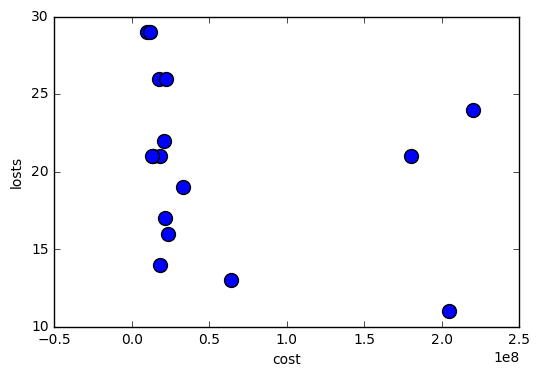

In [14]:
teams_pd.plot.scatter(x='cost', y='losts', s=100)

Удаляем колонку с именами

In [15]:
del teams_pd['name']
teams_pd

,cost,losts
0,21125000.0,22
1,204900000.0,11
2,9950000.0,29
3,17725000.0,26
4,220250000.0,24
5,18275000.0,14
6,11575000.0,29
7,180150000.0,21
8,14025000.0,21
9,18025000.0,21


Нормализация данных

In [16]:
whitened = whiten(teams_pd.as_matrix())
whitened

array([[ 0.29538773,  4.17747144],
       [ 2.86508619,  2.08873572],
       [ 0.13912937,  5.50666689],
       [ 0.24784604,  4.9370117 ],
       [ 3.07972296,  4.55724157],
       [ 0.2555366 ,  2.65839091],
       [ 0.1618515 ,  5.50666689],
       [ 2.51901063,  3.98758637],
       [ 0.19610949,  3.98758637],
       [ 0.25204089,  3.98758637],
       [ 0.29643644,  3.22804611],
       [ 0.33069443,  3.03816104],
       [ 0.45933666,  3.60781624],
       [ 0.8921059 ,  2.46850585],
       [ 0.18107792,  3.98758637],
       [ 0.30657401,  4.9370117 ]])

### Сделаем 3 кластера

In [17]:
centroids, cluster_map = kmeans2(whitened, 3)
centroids, cluster_map

(array([[ 0.44682201,  3.00018403],
        [ 2.82127326,  3.54452122],
        [ 0.22250212,  4.62844847]]),
 array([2, 1, 2, 2, 1, 0, 2, 1, 2, 2, 0, 0, 0, 0, 2, 2]))

Зададим цвета для каждого кластера

In [18]:
colors_map = {0: 'r', 1: 'g', 2: 'b', 3: 'y', 4: 'm'}
colors = [colors_map[c] for c in cluster_map]
colors

['b',
 'g',
 'b',
 'b',
 'g',
 'r',
 'b',
 'g',
 'b',
 'b',
 'r',
 'r',
 'r',
 'r',
 'b',
 'b']

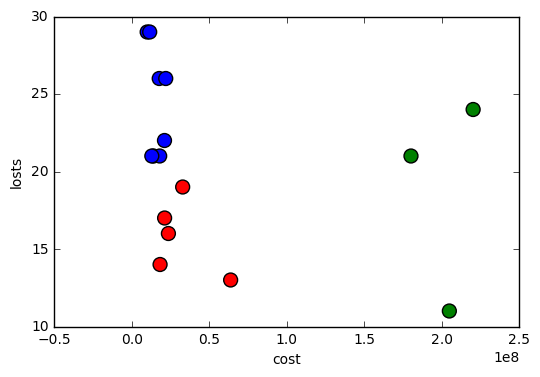

In [19]:
teams_pd.plot.scatter(x='cost', y='losts', c=colors, s=100)

### Теперь попробуем сделать больше кластеров (5 кластеров)

In [20]:
centroids, cluster_map = kmeans2(whitened, 5)
centroids, cluster_map

(array([[ 0.21385023,  5.2218393 ],
        [ 0.27679054,  3.94960936],
        [ 2.79936679,  4.27241397],
        [ 0.44369334,  2.84827598],
        [ 2.86508619,  2.08873572]]),
 array([1, 4, 0, 0, 2, 3, 0, 2, 1, 1, 3, 3, 1, 3, 1, 0]))

In [21]:
colors_map = {0: 'r', 1: 'g', 2: 'b', 3: 'y', 4: 'm'}
colors = [colors_map[c] for c in cluster_map]
colors

['g',
 'm',
 'r',
 'r',
 'b',
 'y',
 'r',
 'b',
 'g',
 'g',
 'y',
 'y',
 'g',
 'y',
 'g',
 'r']

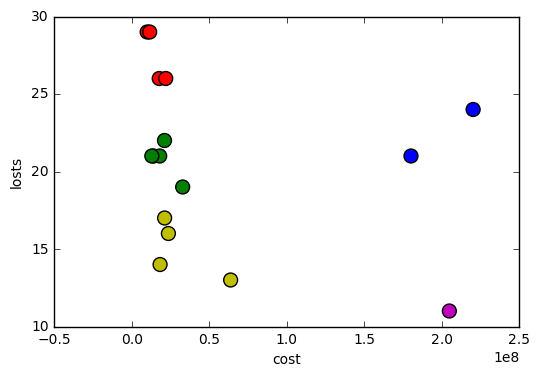

In [22]:
teams_pd.plot.scatter(x='cost', y='losts', c=colors, s=100)